https://analyticsindiamag.com/a-complete-tutorial-on-ordinal-regression-in-python/

# A complete tutorial on Ordinal Regression in Python

+ В статистике и машинном обучении ordinal (порядковая) регрессия - это вариант регрессионных моделей, который обычно используется, когда данные имеют порядковую переменную. 
+ Порядковая переменная - это тип переменной, в которой значения являются категориальными, но расположены по порядку.


Порядковую регрессию можно разделить на две категории:

+ Модель упорядоченного логита (Ordered logit model:): Мы также можем назвать эту модель упорядоченной логистической моделью (ordered logistic model). Например, у нас есть отзывы о каком-либо продукте в опросе как о плохом, хорошем, приятном и отличном, и мы хотим проанализировать, насколько хорошо эти ответы могут быть предсказаны для следующего продукта. Если вопросы количественные, то мы можем использовать эту модель. Мы можем думать о ней как о расширении логистической регрессии, которая позволяет использовать более двух категорий ответов, расположенных в упорядоченном порядке.  

+ Модель упорядоченного пробита (Ordered probit model): Эту модель можно рассматривать как вариант пробит-модели, но с порядковой зависимой переменной, в которой может быть более двух исходов. Порядковая зависимая переменная может быть определена как переменная, в которой значения имеют естественный порядок, например, плохой, хороший, хороший, отличный.

Для проведения порядковой регрессии мы можем использовать обобщенную линейную модель (GLM). 

GLM позволяет подгонять к данным вектор коэффициентов и набор пороговых значений. 

Допустим, в наборе данных есть наблюдения, представленные векторами длины p от X1 до Xn, и против этих наблюдений есть ответы от Y1 до Yn, в ответах каждая переменная является порядковой переменной. 

Мы можем представить Y как неубывающий вектор и применить вектор коэффициентов длины p и набор пороговых значений. 

Набор пороговых значений отвечает за разбиение линии действительных чисел на сегменты, соответствующие уровням ответов, которые аналогичны количеству сегментов.




In [2]:
import pandas as pd
import numpy as np

file = 'data singles/diamonds.csv'
data_diam = pd.read_csv(file)
data_diam.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
# категорийная переменная cut 
data_diam['cut'].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [4]:
data_diam.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

## Data preprocessing 

Здесь мы видим, что у нас есть три переменные типа object, и в этой статье мы имеем дело с переменной cut. 

Для работы с порядковыми моделями из statsmodel нам необходимо преобразовать эту целевую переменную в категориальную упорядоченную форму, что можно сделать с помощью следующих строк кода:

In [6]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Fair', 'Good', 'Ideal', 'Very Good', 'Premium'], ordered=True)
data_diam['cut'] = data_diam['cut'].astype(cat_type)
data_diam['cut'].dtype

CategoricalDtype(categories=['Fair', 'Good', 'Ideal', 'Very Good', 'Premium'], ordered=True)

+ Теперь в данных у нас есть переменные X, Y и Z, которые представляют собой высоту, ширину и глубину алмаза. 
+ Перемножив их, мы можем вычислить объем бриллианта. Давайте вычислим объем.

In [8]:
data_diam['volume'] = data_diam['x'] * data_diam['y'] * data_diam['z']
data_diam.drop(['x', 'y', 'z'], axis=1, inplace=True)
data_diam.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,volume
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,38.202030
1,2,0.21,Premium,E,SI1,59.8,61.0,326,34.505856
2,3,0.23,Good,E,VS1,56.9,65.0,327,38.076885
3,4,0.29,Premium,I,VS2,62.4,58.0,334,46.724580
4,5,0.31,Good,J,SI2,63.3,58.0,335,51.917250


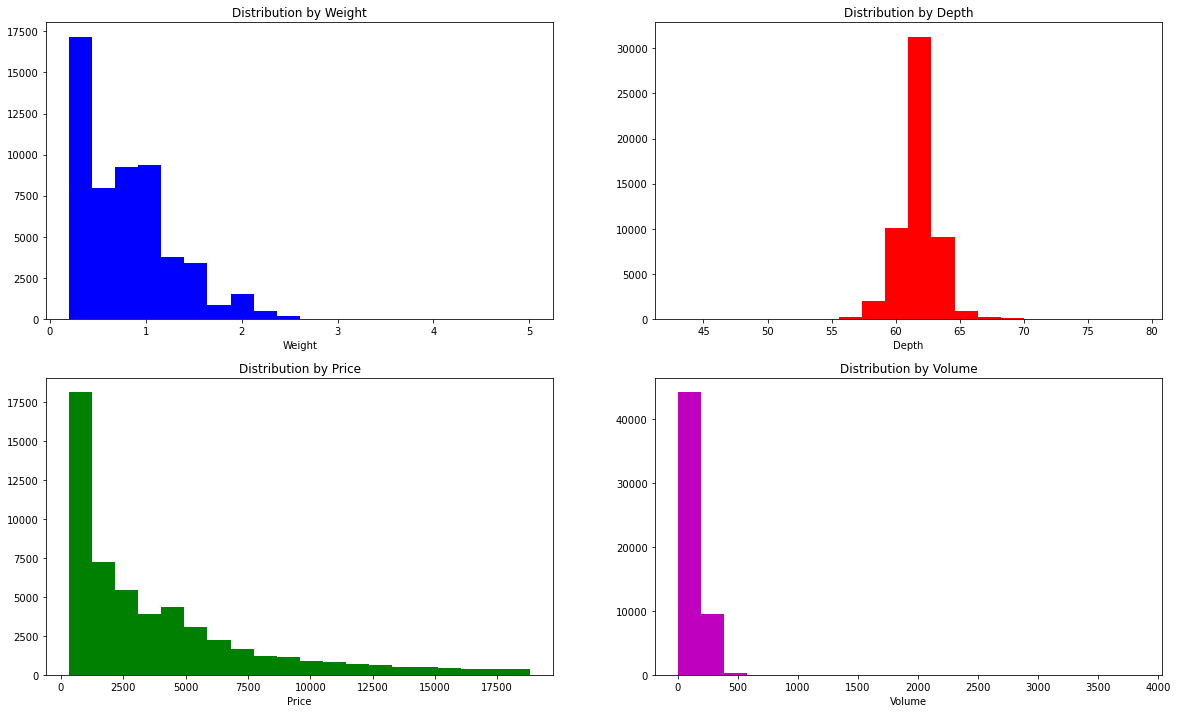

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,12])

plt.subplot(221)
plt.hist(data_diam['carat'], bins=20, color='b')
plt.xlabel('Weight')
plt.title('Distribution by Weight')

plt.subplot(222)
plt.hist(data_diam['depth'], bins=20, color='r')
plt.xlabel('Depth')
plt.title('Distribution by Depth')

plt.subplot(223)
plt.hist(data_diam['price'], bins=20, color='g')
plt.xlabel('Price')
plt.title('Distribution by Price')

plt.subplot(224)
plt.hist(data_diam['volume'], bins=20, color='m')
plt.xlabel('Volume')
plt.title('Distribution by Volume')

plt.show()

## Fitting Ordinal Regression
### Ordered probit model

In [37]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 22 20:24:42 2015

Author: Josef Perktold
License: BSD-3
"""

import warnings

from statsmodels.compat.pandas import Appender

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy import stats

from statsmodels.base.model import (
    Model,
    LikelihoodModel,
    GenericLikelihoodModel,
    GenericLikelihoodModelResults,
)
import statsmodels.base.wrapper as wrap
# for results wrapper:
import statsmodels.regression.linear_model as lm
from statsmodels.tools.decorators import cache_readonly


class OrderedModel(GenericLikelihoodModel):
    """Ordinal Model based on logistic or normal distribution

    The parameterization corresponds to the proportional odds model in the
    logistic case.
    The model assumes that the endogenous variable is ordered but that the
    labels have no numeric interpretation besides the ordering.

    The model is based on a latent linear variable, where we observe only a
    discretization.

    y_latent = X beta + u

    The observed variable is defined by the interval

    y = {0 if y_latent <= cut_0
         1 of cut_0 < y_latent <= cut_1
         ...
         K if cut_K < y_latent

    The probability of observing y=k conditional on the explanatory variables
    X is given by

    prob(y = k | x) = Prob(cut_k < y_latent <= cut_k+1)
                    = Prob(cut_k - x beta < u <= cut_k+1 - x beta
                    = F(cut_k+1 - x beta) - F(cut_k - x beta)

    Where F is the cumulative distribution of u which is either the normal
    or the logistic distribution, but can be set to any other continuous
    distribution. We use standardized distributions to avoid identifiability
    problems.

    Parameters
    ----------
    endog : array_like
        Endogenous or dependent ordered categorical variable with k levels.
        Labels or values of endog will internally transformed to consecutive
        integers, 0, 1, 2, ...
        pd.Series with ordered Categorical as dtype should be preferred as it
        gives the order relation between the levels.
        If endog is not a pandas Categorical, then categories are
        sorted in lexicographic order (by numpy.unique).
    exog : array_like
        Exogenous, explanatory variables. This should not include an intercept.
        pd.DataFrame are also accepted.
        see Notes about constant when using formulas
    offset : array_like
        Offset is added to the linear prediction with coefficient equal to 1.
    distr : string 'probit' or 'logit', or a distribution instance
        The default is currently 'probit' which uses the normal distribution
        and corresponds to an ordered Probit model. The distribution is
        assumed to have the main methods of scipy.stats distributions, mainly
        cdf, pdf and ppf. The inverse cdf, ppf, is only use to calculate
        starting values.

    Notes
    -----
    Status: experimental, core results are verified, still subclasses
    `GenericLikelihoodModel` which will change in future versions.

    The parameterization of OrderedModel requires that there is no constant in
    the model, neither explicit nor implicit. The constant is equivalent to
    shifting all thresholds and is therefore not separately identified.

    Patsy's formula specification does not allow a design matrix without
    explicit or implicit constant if there are categorical variables (or maybe
    splines) among explanatory variables. As workaround, statsmodels removes an
    explicit intercept.

    Consequently, there are two valid cases to get a design matrix without
    intercept when using formulas:

    - specify a model without explicit and implicit intercept which is possible
      if there are only numerical variables in the model.
    - specify a model with an explicit intercept which statsmodels will remove.

    Models with an implicit intercept will be overparameterized, the parameter
    estimates will not be fully identified, cov_params will not be invertible
    and standard errors might contain nans. The computed results will be
    dominated by numerical imprecision coming mainly from convergence tolerance
    and numerical derivatives.

    The model will raise a ValueError if a remaining constant is detected.

    """
    _formula_max_endog = np.inf

    def __init__(self, endog, exog, offset=None, distr='probit', **kwds):

        if distr == 'probit':
            self.distr = stats.norm
        elif distr == 'logit':
            self.distr = stats.logistic
        else:
            self.distr = distr

        if offset is not None:
            offset = np.asarray(offset)

        self.offset = offset

        endog, labels, is_pandas = self._check_inputs(endog, exog)

        super(OrderedModel, self).__init__(endog, exog, **kwds)
        k_levels = None  # initialize
        if not is_pandas:
            if self.endog.ndim == 1:
                unique, index = np.unique(self.endog, return_inverse=True)
                self.endog = index
                labels = unique
                if np.isnan(labels).any():
                    msg = ("NaN in dependent variable detected. "
                           "Missing values need to be removed.")
                    raise ValueError(msg)
            elif self.endog.ndim == 2:
                if not hasattr(self, "design_info"):
                    raise ValueError("2-dim endog not supported")
                # this branch is currently only in support of from_formula
                # we need to initialize k_levels correctly for df_resid
                k_levels = self.endog.shape[1]
                labels = []
                # Note: Doing the following here would break from_formula
                # self.endog = self.endog.argmax(1)

        if self.k_constant > 0:
            raise ValueError("There should not be a constant in the model")

        self._initialize_labels(labels, k_levels=k_levels)

        # adjust df
        self.k_extra = self.k_levels - 1
        self.df_model = self.k_vars
        self.df_resid = self.nobs - (self.k_vars + self.k_extra)

        self.results_class = OrderedResults

    def _check_inputs(self, endog, exog):
        """Handle endog that is pandas Categorical.

        Checks if self.distrib is legal and provides Pandas ordered Categorical
        support for endog.

        Parameters
        ----------
        endog : array_like
            Endogenous, dependent variable, 1-D.
        exog : array_like
            Exogenous, explanatory variables.
            Currently not used.

        Returns
        -------
        endog : array_like or pandas Series
            If the original endog is a pandas ordered Categorical Series,
            then the returned endog are the ``codes``, i.e. integer
            representation of ordere categorical variable
        labels : None or list
            If original endog is pandas ordered Categorical Series, then the
            categories are returned. Otherwise ``labels`` is None.
        is_pandas : bool
            This is True if original endog is a pandas ordered Categorical
            Series and False otherwise.

        """

        if not isinstance(self.distr, stats.rv_continuous):
            msg = (
                f"{self.distr.name} is not a scipy.stats distribution."
            )
            warnings.warn(msg)

        labels = None
        is_pandas = False
        if isinstance(endog, pd.Series):
            if isinstance(endog.dtypes, CategoricalDtype):
                if not endog.dtype.ordered:
                    warnings.warn("the endog has ordered == False, "
                                  "risk of capturing a wrong order for the "
                                  "categories. ordered == True preferred.",
                                  Warning)

                endog_name = endog.name
                labels = endog.values.categories
                endog = endog.cat.codes
                if endog.min() == -1:  # means there is a missing value
                    raise ValueError("missing values in categorical endog are "
                                     "not supported")
                endog.name = endog_name
                is_pandas = True

        return endog, labels, is_pandas

    def _initialize_labels(self, labels, k_levels=None):
        self.labels = labels
        if k_levels is None:
            self.k_levels = len(labels)
        else:
            self.k_levels = k_levels

        if self.exog is not None:
            self.nobs, self.k_vars = self.exog.shape
        else:  # no exog in model
            self.nobs, self.k_vars = self.endog.shape[0], 0

        threshold_names = [str(x) + '/' + str(y)
                           for x, y in zip(labels[:-1], labels[1:])]

        # from GenericLikelihoodModel.fit
        if self.exog is not None:
            # avoid extending several times
            if len(self.exog_names) > self.k_vars:
                raise RuntimeError("something wrong with exog_names, too long")
            self.exog_names.extend(threshold_names)
        else:
            self.data.xnames = threshold_names

    @classmethod
    def from_formula(cls, formula, data, subset=None, drop_cols=None,
                     *args, **kwargs):

        # we want an explicit Intercept in the model that we can remove
        # Removing constant with "0 +" or "- 1" does not work for categ. exog

        endog_name = formula.split("~")[0].strip()
        original_endog = data[endog_name]

        model = super(OrderedModel, cls).from_formula(
            formula, data=data, drop_cols=["Intercept"], *args, **kwargs)

        if model.endog.ndim == 2:
            if not (isinstance(original_endog.dtype, CategoricalDtype)
                    and original_endog.dtype.ordered):
                msg = ("Only ordered pandas Categorical are supported as "
                       "endog in formulas")
                raise ValueError(msg)

            labels = original_endog.values.categories
            model._initialize_labels(labels)
            model.endog = model.endog.argmax(1)
            model.data.ynames = endog_name

        return model

    from_formula.__func__.__doc__ = Model.from_formula.__doc__


    def cdf(self, x):
        """Cdf evaluated at x.

        Parameters
        ----------
        x : array_like
            Points at which cdf is evaluated. In the model `x` is the latent
            variable plus threshold constants.

        Returns
        -------
        Value of the cumulative distribution function of the underlying latent
        variable evaluated at x.
        """
        return self.distr.cdf(x)

    def pdf(self, x):
        """Pdf evaluated at x

        Parameters
        ----------
        x : array_like
            Points at which cdf is evaluated. In the model `x` is the latent
            variable plus threshold constants.

        Returns
        -------
        Value of the probability density function of the underlying latent
        variable evaluated at x.
        """
        return self.distr.pdf(x)

    def prob(self, low, upp):
        """Interval probability.

        Probability that value is in interval (low, upp], computed as

            prob = cdf(upp) - cdf(low)

        Parameters
        ----------
        low : array_like
            lower bound for interval
        upp : array_like
            upper bound for interval

        Returns
        -------
        float or ndarray
            Probability that value falls in interval (low, upp]

        """
        return np.maximum(self.cdf(upp) - self.cdf(low), 0)

    def transform_threshold_params(self, params):
        """transformation of the parameters in the optimization

        Parameters
        ----------
        params : nd_array
            Contains (exog_coef, transformed_thresholds) where exog_coef are
            the coefficient for the explanatory variables in the linear term,
            transformed threshold or cutoff points. The first, lowest threshold
            is unchanged, all other thresholds are in terms of exponentiated
            increments.

        Returns
        -------
        thresh : nd_array
            Thresh are the thresholds or cutoff constants for the intervals.

        """
        th_params = params[-(self.k_levels - 1):]
        thresh = np.concatenate((th_params[:1],
                                 np.exp(th_params[1:]))).cumsum()
        thresh = np.concatenate(([-np.inf], thresh, [np.inf]))
        return thresh

    def transform_reverse_threshold_params(self, params):
        """obtain transformed thresholds from original thresholds or cutoffs

        Parameters
        ----------
        params : ndarray
            Threshold values, cutoff constants for choice intervals, which
            need to be monotonically increasing.

        Returns
        -------
        thresh_params : ndarrray
            Transformed threshold parameter.
            The first, lowest threshold is unchanged, all other thresholds are
            in terms of exponentiated increments.
            Transformed parameters can be any real number without restrictions.

        """
        thresh_params = np.concatenate((params[:1],
                                        np.log(np.diff(params[:-1]))))
        return thresh_params

    def predict(self, params, exog=None, offset=None, which="prob"):
        """
        Predicted probabilities for each level of the ordinal endog.

        Parameters
        ----------
        params : ndarray
            Parameters for the Model, (exog_coef, transformed_thresholds).
        exog : array_like, optional
            Design / exogenous data. If exog is None, model exog is used.
        offset : array_like, optional
            Offset is added to the linear prediction with coefficient
            equal to 1. If offset is not provided and exog
            is None, uses the model's offset if present.  If not, uses
            0 as the default value.
        which : {"prob", "linpred", "cumprob"}
            Determines which statistic is predicted.

            - prob : predicted probabilities to be in each choice. 2-dim.
            - linear : 1-dim linear prediction of the latent variable
              ``x b + offset``
            - cumprob : predicted cumulative probability to be in choice k or
              lower

        Returns
        -------
        predicted values : ndarray
            If which is "prob", then 2-dim predicted probabilities with
            observations in rows and one column for each category or level of
            the categorical dependent variable.
            If which is "cumprob", then "prob" ar cumulatively added to get the
            cdf at k, i.e. probability of observing choice k or lower.
            If which is "linpred", then the conditional prediction of the
            latent variable is returned. In this case, the return is
            one-dimensional.
        """
        # note, exog and offset handling is in linpred

        thresh = self.transform_threshold_params(params)
        xb = self._linpred(params, exog=exog, offset=offset)
        if which == "linpred":
            return xb
        xb = xb[:, None]
        low = thresh[:-1] - xb
        upp = thresh[1:] - xb
        if which == "prob":
            prob = self.prob(low, upp)
            return prob
        elif which in ["cum", "cumprob"]:
            cumprob = self.cdf(upp)
            return cumprob
        else:
            raise ValueError("`which` is not available")

    def _linpred(self, params, exog=None, offset=None):
        """Linear prediction of latent variable `x b + offset`.

        Parameters
        ----------
        params : ndarray
            Parameters for the model, (exog_coef, transformed_thresholds)
        exog : array_like, optional
            Design / exogenous data. Is exog is None, model exog is used.
        offset : array_like, optional
            Offset is added to the linear prediction with coefficient
            equal to 1. If offset is not provided and exog
            is None, uses the model's offset if present.  If not, uses
            0 as the default value.

        Returns
        -------
        linear : ndarray
            1-dim linear prediction given by exog times linear params plus
            offset. This is the prediction for the underlying latent variable.
            If exog and offset are None, then the predicted values are zero.

        """
        if exog is None:
            exog = self.exog
            if offset is None:
                offset = self.offset
        else:
            if offset is None:
                offset = 0

        if offset is not None:
            offset = np.asarray(offset)

        if exog is not None:
            _exog = np.asarray(exog)
            _params = np.asarray(params)
            linpred = _exog.dot(_params[:-(self.k_levels - 1)])
        else:  # means self.exog is also None
            linpred = np.zeros(self.nobs)
        if offset is not None:
            linpred += offset
        return linpred

    def _bounds(self, params):
        """Integration bounds for the observation specific interval.

        This defines the lower and upper bounds for the intervals of the
        choices of all observations.

        The bounds for observation are given by

            a_{k_i-1} - linpred_i, a_k_i - linpred_i

        where
        - k_i is the choice in observation i.
        - a_{k_i-1} and a_k_i are thresholds (cutoffs) for choice k_i
        - linpred_i is the linear prediction for observation i

        Parameters
        ----------
        params : ndarray
            Parameters for the model, (exog_coef, transformed_thresholds)

        Return
        ------
        low : ndarray
            Lower bounds for choice intervals of each observation,
            1-dim with length nobs
        upp : ndarray
            Upper bounds for choice intervals of each observation,
            1-dim with length nobs.

        """
        thresh = self.transform_threshold_params(params)

        thresh_i_low = thresh[self.endog]
        thresh_i_upp = thresh[self.endog + 1]
        xb = self._linpred(params)
        low = thresh_i_low - xb
        upp = thresh_i_upp - xb
        return low, upp

    @Appender(GenericLikelihoodModel.loglike.__doc__)
    def loglike(self, params):

        return self.loglikeobs(params).sum()

    def loglikeobs(self, params):
        """
        Log-likelihood of OrderdModel for all observations.

        Parameters
        ----------
        params : array_like
            The parameters of the model.

        Returns
        -------
        loglike_obs : array_like
            The log likelihood for each observation of the model evaluated
            at ``params``.
        """
        low, upp = self._bounds(params)
        prob = self.prob(low, upp)
        return np.log(prob + 1e-20)

    def score_obs_(self, params):
        """score, first derivative of loglike for each observations

        This currently only implements the derivative with respect to the
        exog parameters, but not with respect to threshold parameters.

        """
        low, upp = self._bounds(params)

        prob = self.prob(low, upp)
        pdf_upp = self.pdf(upp)
        pdf_low = self.pdf(low)

        # TODO the following doesn't work yet because of the incremental exp
        # parameterization. The following was written based on Greene for the
        # simple non-incremental parameterization.
        # k = self.k_levels - 1
        # idx = self.endog
        # score_factor = np.zeros((self.nobs, k + 1 + 2)) #+2 avoids idx bounds
        #
        # rows = np.arange(self.nobs)
        # shift = 1
        # score_factor[rows, shift + idx-1] = -pdf_low
        # score_factor[rows, shift + idx] = pdf_upp
        # score_factor[:, 0] = pdf_upp - pdf_low
        score_factor = (pdf_upp - pdf_low)[:, None]
        score_factor /= prob[:, None]

        so = np.column_stack((-score_factor[:, :1] * self.exog,
                              score_factor[:, 1:]))
        return so

    @property
    def start_params(self):
        """Start parameters for the optimization corresponding to null model.

        The threshold are computed from the observed frequencies and
        transformed to the exponential increments parameterization.
        The parameters for explanatory variables are set to zero.
        """
        # start params based on model without exog
        freq = np.bincount(self.endog) / len(self.endog)
        start_ppf = self.distr.ppf(np.clip(freq.cumsum(), 0, 1))
        start_threshold = self.transform_reverse_threshold_params(start_ppf)
        start_params = np.concatenate((np.zeros(self.k_vars), start_threshold))
        return start_params

    @Appender(LikelihoodModel.fit.__doc__)
    def fit(self, start_params=None, method='nm', maxiter=500, full_output=1,
            disp=1, callback=None, retall=0, **kwargs):

        fit_method = super(OrderedModel, self).fit
        mlefit = fit_method(start_params=start_params,
                            method=method, maxiter=maxiter,
                            full_output=full_output,
                            disp=disp, callback=callback, **kwargs)
        # use the proper result class
        ordmlefit = OrderedResults(self, mlefit)

        # TODO: temporary, needs better fix, modelwc adds 1 by default
        ordmlefit.hasconst = 0

        result = OrderedResultsWrapper(ordmlefit)

        return result


class OrderedResults(GenericLikelihoodModelResults):
    """Results class for OrderedModel

    This class inherits from GenericLikelihoodModelResults and not all
    inherited methods might be appropriate in this case.
    """

    def pred_table(self):
        """prediction table

        returns pandas DataFrame

        """
        # todo: add category labels
        categories = np.arange(self.model.k_levels)
        observed = pd.Categorical(self.model.endog,
                                  categories=categories, ordered=True)
        predicted = pd.Categorical(self.predict().argmax(1),
                                   categories=categories, ordered=True)
        table = pd.crosstab(predicted,
                            observed.astype(int),
                            margins=True,
                            dropna=False).T.fillna(0)
        return table

    @cache_readonly
    def llnull(self):
        """
        Value of the loglikelihood of model without explanatory variables
        """
        params_null = self.model.start_params
        return self.model.loglike(params_null)

    # next 3 are copied from discrete
    @cache_readonly
    def prsquared(self):
        """
        McFadden's pseudo-R-squared. `1 - (llf / llnull)`
        """
        return 1 - self.llf/self.llnull

    @cache_readonly
    def llr(self):
        """
        Likelihood ratio chi-squared statistic; `-2*(llnull - llf)`
        """
        return -2*(self.llnull - self.llf)

    @cache_readonly
    def llr_pvalue(self):
        """
        The chi-squared probability of getting a log-likelihood ratio
        statistic greater than llr.  llr has a chi-squared distribution
        with degrees of freedom `df_model`.
        """
        # number of restrictions is number of exog
        return stats.distributions.chi2.sf(self.llr, self.model.k_vars)

    @cache_readonly
    def resid_prob(self):
        """probability residual

        Probability-scale residual is ``P(Y < y) − P(Y > y)`` where `Y` is the
        observed choice and ``y`` is a random variable corresponding to the
        predicted distribution.

        References
        ----------
        Shepherd BE, Li C, Liu Q (2016) Probability-scale residuals for
        continuous, discrete, and censored data.
        The Canadian Journal of Statistics. 44:463–476.

        Li C and Shepherd BE (2012) A new residual for ordinal outcomes.
        Biometrika. 99: 473–480

        """
        from statsmodels.stats.diagnostic_gen import prob_larger_ordinal_choice
        endog = self.model.endog
        fitted = self.predict()
        r = prob_larger_ordinal_choice(fitted)[1]
        resid_prob = r[np.arange(endog.shape[0]), endog]
        return resid_prob


class OrderedResultsWrapper(lm.RegressionResultsWrapper):
    pass


wrap.populate_wrapper(OrderedResultsWrapper, OrderedResults)

In [38]:
mob_prob = OrderedModel(data_diam['cut'],
                       data_diam[['volume', 'price', 'carat']], 
                       distr='probit')

In [39]:
res_prob = mob_prob.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 1.369122
         Iterations: 29
         Function evaluations: 35
         Gradient evaluations: 35


In [40]:
res_prob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                    cut   Log-Likelihood:                -73850.
Model:                   OrderedModel   AIC:                         1.477e+05
Method:            Maximum Likelihood   BIC:                         1.477e+05
Date:                Tue, 19 Mar 2024                                         
Time:                        16:00:04                                         
No. Observations:               53940                                         
Df Residuals:                   53933                                         
Df Model:                           3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
volume                0.0060      0.001     10.108      0.000       0.005       0.007
price              3.511e-05   3.01e-06     11.658      0.000    2.92e-05     4.1e-05
carat                -1.1049      0.097    -11.353      0.000      -1.296      -0.914
Fair/Good            -1.8589      0.016   -119.403      0.000      -1.889      -1.828
Good/Ideal           -0.3292      0.014    -24.056      0.000      -0.356      -0.302
Ideal/Very Good       0.2053      0.006     35.080      0.000       0.194       0.217
Very Good/Premium    -0.4986      0.008    -60.605      0.000      -0.515      -0.483
=====================================================================================
"""

### Ordered logit regression 

In [41]:
mob_prob = OrderedModel(data_diam['cut'],
                       data_diam[['volume', 'price', 'carat']], 
                       distr='logit')
res_log = mob_prob.fit(method='bfgs')
res_log.summary()

Optimization terminated successfully.
         Current function value: 1.369215
         Iterations: 36
         Function evaluations: 42
         Gradient evaluations: 42


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                    cut   Log-Likelihood:                -73855.
Model:                   OrderedModel   AIC:                         1.477e+05
Method:            Maximum Likelihood   BIC:                         1.477e+05
Date:                Tue, 19 Mar 2024                                         
Time:                        16:02:32                                         
No. Observations:               53940                                         
Df Residuals:                   53933                                         
Df Model:                           3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
volume                0.0104      0.002      5.875      0.000       0.007       0.014
price              2.348e-05   5.31e-06      4.425      0.000    1.31e-05    3.39e-05
carat                -1.5407      0.286     -5.394      0.000      -2.100      -0.981
Fair/Good            -3.2836      0.031   -105.758      0.000      -3.344      -3.223
Good/Ideal            0.4038      0.015     27.062      0.000       0.375       0.433
Ideal/Very Good       0.7301      0.006    116.508      0.000       0.718       0.742
Very Good/Premium    -0.0055      0.008     -0.653      0.514      -0.022       0.011
=====================================================================================
"""

In [49]:
# Now we can make the prediction from the model
predicted = res_log.model.predict(res_log.params, 
                                 exog=data_diam[['volume', 'price', 'carat']])
predicted = pd.DataFrame(predicted)
predicted.columns = ['Fair', 'Good', 'Ideal', 'Very Good', 'Premium']
predicted.head(10)

,Fair,Good,Ideal,Very Good,Premium
0,0.034436,0.103082,0.422018,0.214953,0.225510
1,0.034689,0.103730,0.422982,0.214408,0.224191
2,0.034479,0.103191,0.422181,0.214861,0.225288
3,0.034561,0.103403,0.422497,0.214683,0.224856
4,0.033797,0.101438,0.419519,0.216332,0.228914
5,0.034772,0.103944,0.423299,0.214227,0.223758
6,0.034725,0.103822,0.423119,0.214330,0.224005
7,0.034542,0.103355,0.422425,0.214724,0.224954
8,0.034529,0.103320,0.422374,0.214753,0.225024
9,0.034249,0.102602,0.421295,0.215357,0.226497


In [51]:
data_diam.head(40)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,volume
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,38.202030
1,2,0.21,Premium,E,SI1,59.8,61.0,326,34.505856
2,3,0.23,Good,E,VS1,56.9,65.0,327,38.076885
3,4,0.29,Premium,I,VS2,62.4,58.0,334,46.724580
4,5,0.31,Good,J,SI2,63.3,58.0,335,51.917250
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,38.693952
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,38.830870
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,42.321081
8,9,0.22,Fair,E,VS2,65.1,61.0,337,36.425214
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,38.718000


In [50]:
predicted = res_log.model.predict(res_log.params, 
                                 exog=[[36.425214,337,0.22]])
predicted

array([[0.03452882, 0.10332035, 0.42237385, 0.21475274, 0.22502425]])

'Fair', 'Good', 'Ideal', 'Very Good', 'Premium'